In [2]:
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

### Load Trained YOLO Models

In [3]:
# ball_model = YOLO("models/ball_best_v8_30e.pt")
# table_model = YOLO("models/table_yolo_v11_20e.pt")
table_model = YOLO("models/table_yolo_v11_10e.pt")
ball_model = YOLO("models/ball_best_v11_15e.pt")

In [4]:
def order_points_from_short_sides_adaptive(pts):
    """
    Hybrid version:
    - If the table is clearly vertical (height >> width), use top/bottom quadrant logic.
    - Else, use the robust short-side vector sorting.
    Returns corners in TL, TR, BR, BL order.
    """
    pts = np.array(pts, dtype=np.float32)

    # Step 1: Compute bounding box
    min_x, max_x = np.min(pts[:, 0]), np.max(pts[:, 0])
    min_y, max_y = np.min(pts[:, 1]), np.max(pts[:, 1])
    width = max_x - min_x
    height = max_y - min_y

    if height > 1.2 * width:
        # ⚠️ Table is vertical
        center_y = (min_y + max_y) / 2
        upper = []
        lower = []
        for pt in pts:
            if pt[1] < center_y:
                upper.append(pt)
            else:
                lower.append(pt)

        if len(upper) != 2 or len(lower) != 2:
            raise ValueError("Unexpected corner distribution in vertical mode.")

        upper = sorted(upper, key=lambda p: p[0])  # left to right
        lower = sorted(lower, key=lambda p: p[0])  # left to right

        tl, tr = upper
        bl, br = lower
        return np.array([tl, tr, br, bl], dtype=np.float32)

    else:
        # ✅ Use the reliable short-side vector-based ordering
        dists = []
        for i, j in itertools.combinations(range(4), 2):
            d = np.linalg.norm(pts[i] - pts[j])
            dists.append((d, i, j))
        dists.sort()
        (_, i1, j1), (_, i2, j2) = dists[:2]

        vec1 = pts[j1] - pts[i1]
        vec2 = pts[j2] - pts[i2]
        if vec1[0] > 0: vec1 = -vec1
        if vec2[0] > 0: vec2 = -vec2
        x1, x2 = vec1[0], vec2[0]

        if x1 < x2:
            left_pair = [pts[i1], pts[j1]]
            right_pair = [pts[i2], pts[j2]]
        else:
            left_pair = [pts[i2], pts[j2]]
            right_pair = [pts[i1], pts[j1]]

        left_pair = sorted(left_pair, key=lambda p: p[1])
        right_pair = sorted(right_pair, key=lambda p: p[1])

        tl, bl = left_pair
        tr, br = right_pair
        return np.array([tl, tr, br, bl], dtype=np.float32)


In [23]:
def order_points_from_short_sides(pts):
    """
    Orders 4 corner points of a rectangle into: [top-left, top-right, bottom-right, bottom-left].
    """
    pts = np.asarray(pts, dtype=np.float32)
    if pts.shape != (4, 2):
        raise ValueError("pts must be shape (4, 2)")

    # Compute all pairwise distances, store pairs
    pairs = list(itertools.combinations(range(4), 2))
    dists = np.linalg.norm(pts[pairs][:, 0] - pts[pairs][:, 1], axis=1)
    idx = np.argsort(dists)[:2]
    short_pairs = [pairs[i] for i in idx]

    # Gather unique indices of short side points (should be 3)
    short_idxs = list(set(i for pair in short_pairs for i in pair))
    if len(short_idxs) != 3:
        raise ValueError("Could not determine two distinct short sides.")

    # Count occurrences to find the shared (corner) index
    counts = {i: sum(i in pair for pair in short_pairs) for i in short_idxs}
    shared = [i for i, c in counts.items() if c == 2][0]
    neighbors = [i for i in short_idxs if i != shared]

    v1, v2 = pts[neighbors[0]] - pts[shared], pts[neighbors[1]] - pts[shared]
    cross = np.cross(v1, v2)
    if cross > 0:
        tl, tr, bl = pts[shared], pts[neighbors[0]], pts[neighbors[1]]
    else:
        tl, tr, bl = pts[shared], pts[neighbors[1]], pts[neighbors[0]]

    br_idx = next(i for i in range(4) if i not in [shared] + neighbors)
    br = pts[br_idx]

    return np.array([tl, tr, br, bl], dtype=np.float32)

In [25]:
def compute_dst_pts_strict(src_pts, long_side=800, short_side=400):
    """
    Returns dst_pts and canvas size (width, height)
    """
    vec_tr = src_pts[1] - src_pts[0]
    angle = np.degrees(np.arctan2(vec_tr[1], vec_tr[0])) % 360

    if 45 < angle < 135:
        # Vertical
        dst_pts = np.array([[0, 0], [0, long_side], [short_side, long_side], [short_side, 0]], dtype=np.float32)
        return dst_pts, short_side, long_side
    else:
        # Horizontal
        dst_pts = np.array([[0, 0], [long_side, 0], [long_side, short_side], [0, short_side]], dtype=np.float32)
        return dst_pts, long_side, short_side


In [16]:
ball_label_to_name = {
    0: "cue_ball",
    1: "8_ball",
    2: "stripe",
    3: "solid"
}

In [30]:
def detect_table_and_map_balls(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read {image_path}")
        return

    height, width = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Table segmentation
    table_results = table_model(image_path)[0]
    if not table_results.masks:
        print("No table segmentation found.")
        return

    mask = table_results.masks[0].data[0].cpu().numpy()
    mask_resized = cv2.resize(mask, (width, height))

    # Get largest contour & approximate
    contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) != 4:
        print(f"Expected 4 corners, got {len(approx)}. Homography will not be applied.")
        return

    src_pts = order_points_from_short_sides([pt[0] for pt in approx])
    dst_pts, dst_width, dst_height = compute_dst_pts_strict(src_pts)
    H, _ = cv2.findHomography(src_pts, dst_pts)
    if H is None:
        print("Failed to compute homography matrix.")
        return

    # 2. Ball detection
    ball_results = ball_model(image_path)[0]
    mapped_positions, ball_labels = [], []

    for box in ball_results.boxes:
        x_c, y_c = box.xywh[0][:2].tolist()
        x_int, y_int = int(np.clip(x_c, 0, width - 1)), int(np.clip(y_c, 0, height - 1))
        if mask_resized[y_int, x_int] < 0.5:
            print(f"Ball at ({x_int}, {y_int}) is outside the table. Skipping.")
            continue

        pt = np.array([[[x_c, y_c]]], dtype=np.float32)
        dst = cv2.perspectiveTransform(pt, H)[0][0]
        if 0 <= dst[0] <= dst_width and 0 <= dst[1] <= dst_height:
            mapped_positions.append(dst)
            ball_labels.append(int(box.cls[0].item()))
        else:
            print(f"⚠️ Skipped out-of-bound mapped point: ({dst[0]:.1f}, {dst[1]:.1f})")

    # 3. Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis("off")
    for box in ball_results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls = int(box.cls[0].item())
        conf = float(box.conf[0])
        axs[0].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
        axs[0].text(x1, y1 - 5, f"{cls} ({conf:.2f})", color='red', fontsize=10)

    axs[1].set_xlim(dst_width, 0)
    axs[1].set_ylim(dst_height, 0)
    axs[1].set_title("2D Top-Down Table View")
    axs[1].set_aspect('equal')
    axs[1].set_facecolor('#1a630f')
    for (x, y), label in zip(mapped_positions, ball_labels):
        axs[1].add_patch(plt.Circle((x, y), 8, color='white', ec='black'))
        axs[1].text(x, y - 10, ball_label_to_name[label], color='white', fontsize=10, ha='center')
    plt.tight_layout()
    plt.show()


image 1/1 c:\Users\Lenovo\Desktop\Machine Learning\Pool_Vision\ball_dataset\images\val\billiard_1445.png: 640x640 1 table_play_area, 513.0ms
Speed: 8.1ms preprocess, 513.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\Lenovo\Desktop\Machine Learning\Pool_Vision\ball_dataset\images\val\billiard_1445.png: 640x640 1 8_ball, 3 stripes, 6 solids, 216.7ms
Speed: 3.9ms preprocess, 216.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


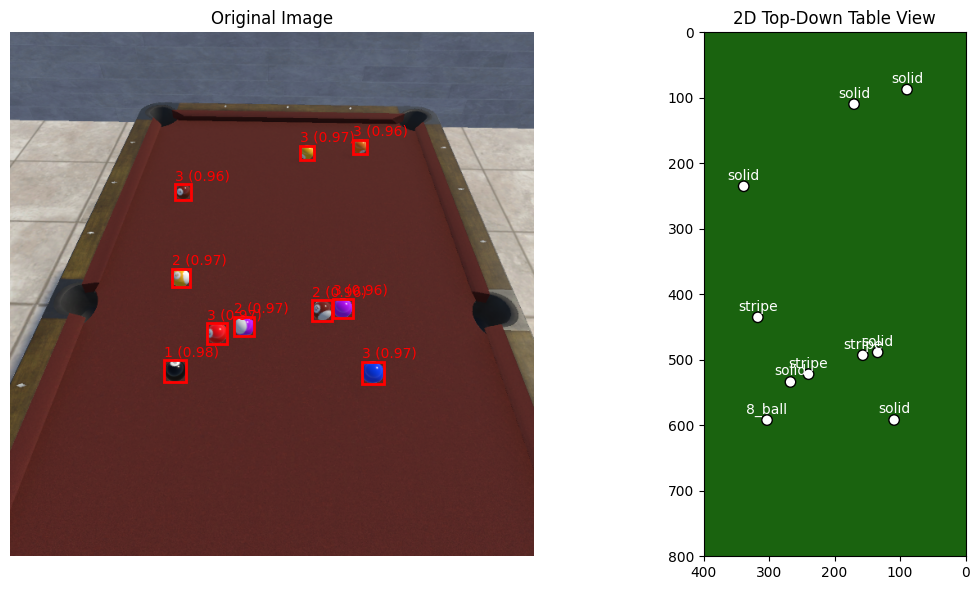

In [31]:
detect_table_and_map_balls("ball_dataset/images/val/billiard_1445.png")